In [1]:
import os
import json
import sqlite3

import pandas as pd
import numpy as np

# for RNN
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# plot
import matplotlib.pyplot as plt

In [2]:
filepath = 'data/'

In [3]:
data = []
time_df = []

for filename in os.listdir(filepath):
    if 'temp' in filename:
        continue
    if filename == '.ipynb_checkpoints':
        continue
    cnx = sqlite3.connect(filepath + filename)
    cnx.text_factory = lambda b: b.decode(errors = 'ignore') #https://stackoverflow.com/questions/22751363/sqlite3-operationalerror-could-not-decode-to-utf-8-column
    df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
    df_ull = pd.read_sql_query("SELECT * FROM COUNTERS_ULL_TIME_DATA", cnx)
    df_data = pd.concat([df_string, df_ull], ignore_index = True)
    start_val = pd.DataFrame({'MEASUREMENT_TIME': df_data.loc[0][0], 'ID_INPUT': 4, 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
    df_data = pd.concat([start_val, df_data])
    data.append(pd.DataFrame(df_data))
    schema = pd.DataFrame(pd.read_sql_query("SELECT * FROM INPUTS", cnx))
    
    # get actual start time
    time_diff = pd.read_sql_query("SELECT * FROM DB_META_DATA", cnx)
    utc_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_UTC']['VALUE'].iloc[0])
    local_open = pd.to_datetime(time_diff[time_diff['KEY'] == 'OPEN_TIME_LOCAL']['VALUE'].iloc[0])
    time_difference = utc_open - local_open
    
    time_sub = df_data[df_data['ID_INPUT'] == 4].copy()
    time_sub['MEASUREMENT_TIME'] = pd.to_datetime(time_sub['MEASUREMENT_TIME'])
    time_sub['MEASUREMENT_TIME'] = time_sub['MEASUREMENT_TIME'] - time_difference
    time_sub['Time_Used'] = time_sub['MEASUREMENT_TIME'].diff().dt.total_seconds()
    time_sub['Time_Used'] = time_sub['Time_Used'].shift(periods = -1)
    time_sub = time_sub.drop(columns = ['PRIVATE_DATA', 'ID_INPUT'])
    time_df.append(time_sub)

In [4]:
df = pd.concat(data, ignore_index = True)

In [5]:
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
df['VALUE'] = df['VALUE'].str.lower()

In [12]:
df.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

In [13]:
df = df.sort_values(by = ['MEASUREMENT_TIME'], ignore_index = True)

In [14]:
df

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2023-01-15 18:20:31.552,4,s0,0
1,2023-01-15 18:20:31.552,0,NaN,0
2,2023-01-15 18:20:31.552,1,NaN,0
3,2023-01-15 18:20:31.552,2,NaN,0
4,2023-01-15 18:20:31.552,6,NaN,0
...,...,...,...,...
87407,2023-02-14 09:18:17.660,5,consolewindowclass,0
87408,2023-02-14 09:18:17.660,10,NaN,0
87409,2023-02-14 09:18:17.660,3,esrv.exe,0
87410,2023-02-14 09:18:17.660,1,NaN,0


In [16]:
df.to_csv('data/temp/data_user1.csv')

In [15]:
df.shape[0]/12 # number of unique entries

7284.333333333333

In [15]:
import numpy as np
import pandas as pd

In [21]:
tmp = df[df.ID_INPUT == 4]

In [23]:
tmp.VALUE.unique()

array(['vsdebugconsole.exe', 'explorer.exe', 'devenv.exe',
       'applicationframehost.exe', 'chrome.exe',
       'shellexperiencehost.exe', 'searchapp.exe',
       'unable to open process', 'snippingtool.exe',
       'db browser for sqlite.exe', 'code.exe',
       'codesetup-stable-97dec172d3256f8ca4bfb2143f3f76b503ca0534.tmp',
       'idman.exe', 'msedge.exe'], dtype=object)

In [24]:
len(tmp.VALUE.unique())

14

In [31]:
tmp.groupby('VALUE').count().sort_values(by="ID_INPUT", ascending=False) # executable can have the extension "tmp"

,MEASUREMENT_TIME,ID_INPUT,PRIVATE_DATA
VALUE,,,
chrome.exe,88,88,88
vsdebugconsole.exe,44,44,44
explorer.exe,43,43,43
msedge.exe,27,27,27
applicationframehost.exe,25,25,25
unable to open process,24,24,24
code.exe,23,23,23
devenv.exe,12,12,12
shellexperiencehost.exe,12,12,12


In [33]:
len(df.PRIVATE_DATA.unique())

1

In [43]:
df = df.assign(date = df["MEASUREMENT_TIME"].astype(str).apply(lambda x: x[:10]))

In [46]:
df.groupby('date').count()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
date,,,,
2023-01-15,2448,2448,612,2448
2023-01-16,1476,1476,369,1476


In [49]:
tab_app = df[df.ID_INPUT == 3]
tab_app.groupby('VALUE').count()

,MEASUREMENT_TIME,ID_INPUT,PRIVATE_DATA,date
VALUE,,,,
.rhistory - visual studio code,1,1,1,1
"74% dan pilone, russ miles - head first ...pdf",1,1,1,1
[cse 110] weekly reading - google docs - google chrome,14,14,14,14
[dsc180b] - google docs - google chrome,1,1,1,1
[dsc180b] weekly homework - google docs - google chrome,1,1,1,1
...,...,...,...,...
visual studio code,2,2,2,2
volume control,10,10,10,10
worked_problems_section_53.pdf - google chrome,3,3,3,3


In [53]:
tab_app['VALUE'][:20]

0                                               esrv.exe
18                                             downloads
28                                              esrv.exe
46            dsc180a_hw_week4 - microsoft visual studio
56                                           movies & tv
68            dsc180a_hw_week4 - microsoft visual studio
82                                              esrv.exe
94                                              esrv.exe
105                                          movies & tv
113                                      missing string.
120                                          movies & tv
142                                            downloads
146                                          movies & tv
166                                            downloads
176                                      missing string.
183                                            downloads
198                                          movies & tv
204    public -- 2022-2023 (ccg

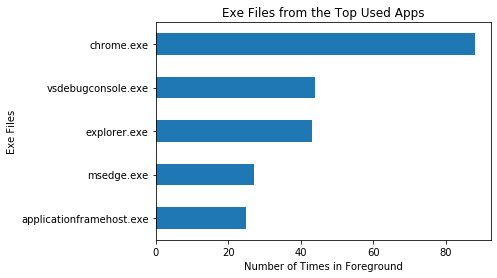

In [9]:
import matplotlib.pyplot as plt
plot = df[df['ID_INPUT'] == 4]['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
plot.set_axisbelow(True)
plot.set_xlabel('Number of Times in Foreground')
plot.set_ylabel('Exe Files')
plot.set_title('Exe Files from the Top Used Apps')
plot.invert_yaxis()
#plt.pyplot.grid(axis = 'x')
#plt.pyplot.show()

### Process data for LSTM

In [17]:
df = pd.read_csv("data/temp/data_user1.csv")
df.head()

,Unnamed: 0,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,0,2023-01-15 18:20:31.552,4,s0,0
1,1,2023-01-15 18:20:31.552,0,NaN,0
2,2,2023-01-15 18:20:31.552,1,NaN,0
3,3,2023-01-15 18:20:31.552,2,NaN,0
4,4,2023-01-15 18:20:31.552,6,NaN,0


In [18]:
df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])

In [19]:
df = df.assign(day_of_week = df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%A"))) # https://www.w3schools.com/python/python_datetime.asp

In [20]:
df = df.assign(week_of_year = df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%W")))

In [21]:
df = df.assign(week_day = df['week_of_year'] + '_' + df['day_of_week'])

In [22]:
df = df[df['ID_INPUT'] == 4]

In [23]:
df = df.reset_index()

In [24]:
duration_series = df[df['ID_INPUT'] == 4].groupby('week_day')['MEASUREMENT_TIME'].diff()[1:]
end_point = pd.Series([duration_series[1]])
app_duration = pd.concat([duration_series, end_point], ignore_index=True)

In [25]:
duration_series

1             00:00:00
2      00:00:02.023000
3      00:00:03.031000
4      00:00:03.021000
5      00:00:01.015000
             ...      
7349   00:15:05.282000
7350   00:00:02.014000
7351   01:39:58.296000
7352   00:00:05.040000
7353   01:51:56.610000
Name: MEASUREMENT_TIME, Length: 7353, dtype: timedelta64[ns]

In [26]:
df

,index,Unnamed: 0,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,day_of_week,week_of_year,week_day
0,0,0,2023-01-15 18:20:31.552,4,s0,0,Sunday,02,02_Sunday
1,10,10,2023-01-15 18:20:31.552,4,vsdebugconsole.exe,0,Sunday,02,02_Sunday
2,24,24,2023-01-15 18:20:33.575,4,explorer.exe,0,Sunday,02,02_Sunday
3,36,36,2023-01-15 18:20:36.606,4,vsdebugconsole.exe,0,Sunday,02,02_Sunday
4,45,45,2023-01-15 18:20:39.627,4,devenv.exe,0,Sunday,02,02_Sunday
...,...,...,...,...,...,...,...,...,...
7349,87363,87363,2023-02-14 05:46:15.700,4,shellexperiencehost.exe,0,Tuesday,07,07_Tuesday
7350,87369,87369,2023-02-14 05:46:17.714,4,chrome.exe,0,Tuesday,07,07_Tuesday
7351,87387,87387,2023-02-14 07:26:16.010,4,shellexperiencehost.exe,0,Tuesday,07,07_Tuesday
7352,87398,87398,2023-02-14 07:26:21.050,4,chrome.exe,0,Tuesday,07,07_Tuesday


In [27]:
df = df.assign(app_duration = app_duration)

In [121]:
# import datetime
# datetime.datetime.strptime('00:00:00', '%H:%M:%S').time()

In [28]:
app_delta_time = df.groupby(['VALUE', 'week_day'])['app_duration'].sum().reset_index()

In [29]:
app_delta_time

,VALUE,week_day,app_duration
0,applicationframehost.exe,02_Sunday,00:09:18.960000
1,applicationframehost.exe,03_Friday,00:00:07.076000
2,applicationframehost.exe,03_Monday,00:01:56.999000
3,applicationframehost.exe,03_Sunday,00:00:32.267000
4,applicationframehost.exe,03_Thursday,01:10:32.025000
...,...,...,...
328,zoom.exe,06_Sunday,00:00:18.146000
329,zoom.exe,06_Thursday,00:20:51.459000
330,zoom.exe,06_Tuesday,00:15:51.081000
331,zoom.exe,06_Wednesday,00:07:31.498000


In [32]:
app_delta_time.dtypes

VALUE                    object
week_day                 object
app_duration    timedelta64[ns]
dtype: object

In [33]:
duration_in_hours = app_delta_time['app_duration'].apply(lambda x: x.total_seconds() / 3600)

In [34]:
app_delta_time = app_delta_time.assign(app_duration = duration_in_hours)

In [35]:
app_delta_time[app_delta_time['VALUE'] == 'chrome.exe']

,VALUE,week_day,app_duration
16,chrome.exe,02_Sunday,4.607893
17,chrome.exe,03_Friday,6.220594
18,chrome.exe,03_Monday,9.291753
19,chrome.exe,03_Saturday,6.719089
20,chrome.exe,03_Sunday,6.617694
21,chrome.exe,03_Thursday,4.940132
22,chrome.exe,03_Tuesday,7.757418
23,chrome.exe,03_Wednesday,4.710665
24,chrome.exe,04_Friday,6.688516
25,chrome.exe,04_Monday,5.451440


In [36]:
week = app_delta_time['week_day'].apply(lambda x: int(x[:2]))
one_hot_day_encoded = {
    'Monday': [1,0,0,0,0,0,0],
    'Tuesday': [0,1,0,0,0,0,0],
    'Wednesday': [0,0,1,0,0,0,0],
    'Thursday': [0,0,0,1,0,0,0],
    'Friday': [0,0,0,0,1,0,0],
    'Saturday': [0,0,0,0,0,1,0],
    'Sunday': [0,0,0,0,0,0,1]
}
    
day  = app_delta_time['week_day'].apply(lambda x: one_hot_day_encoded[x[3:]])
app_delta_time = app_delta_time.assign(week = week, day = day)

In [37]:
app_delta_time

,VALUE,week_day,app_duration,week,day
0,applicationframehost.exe,02_Sunday,0.155267,2,"[0, 0, 0, 0, 0, 0, 1]"
1,applicationframehost.exe,03_Friday,0.001966,3,"[0, 0, 0, 0, 1, 0, 0]"
2,applicationframehost.exe,03_Monday,0.032500,3,"[1, 0, 0, 0, 0, 0, 0]"
3,applicationframehost.exe,03_Sunday,0.008963,3,"[0, 0, 0, 0, 0, 0, 1]"
4,applicationframehost.exe,03_Thursday,1.175562,3,"[0, 0, 0, 1, 0, 0, 0]"
...,...,...,...,...,...
328,zoom.exe,06_Sunday,0.005041,6,"[0, 0, 0, 0, 0, 0, 1]"
329,zoom.exe,06_Thursday,0.347628,6,"[0, 0, 0, 1, 0, 0, 0]"
330,zoom.exe,06_Tuesday,0.264189,6,"[0, 1, 0, 0, 0, 0, 0]"
331,zoom.exe,06_Wednesday,0.125416,6,"[0, 0, 1, 0, 0, 0, 0]"


In [62]:
#############
all_time_df = pd.concat(time_df, ignore_index = True)
all_time_df = all_time_df.fillna(0)
all_time_df['Hour'] = all_time_df['MEASUREMENT_TIME'].dt.hour
all_time_df['Date'] = all_time_df["MEASUREMENT_TIME"].astype(str).apply(lambda x: x[:10])
all_time_df['Minute'] = all_time_df['MEASUREMENT_TIME'].dt.minute
all_time_df['Day'] = all_time_df['MEASUREMENT_TIME'].dt.day
all_time_df['Month'] = all_time_df['MEASUREMENT_TIME'].dt.month
all_time_df['Day_Week'] = all_time_df['MEASUREMENT_TIME'].dt.day_name()
all_time_df = all_time_df.assign(Week_Year = all_time_df['MEASUREMENT_TIME'].apply(lambda x: x.strftime("%W")))
all_time_df = all_time_df.assign(Week_Day = all_time_df['Week_Year'] + '_' + all_time_df['Day_Week'])


In [63]:
all_time_df.head(2)

,MEASUREMENT_TIME,VALUE,Time_Used,Hour,Date,Minute,Day,Month,Day_Week,Week_Year,Week_Day
0,2023-01-15 10:20:31.558,s0,0.000,10,2023-01-15,20,15,1,Sunday,02,02_Sunday
1,2023-01-15 10:20:31.558,VsDebugConsole.exe,2.023,10,2023-01-15,20,15,1,Sunday,02,02_Sunday


In [64]:
time_per_week_day = all_time_df.copy()
time_per_week_day['Time_Used'] = time_per_week_day['Time_Used'] / 60 / 60
time_per_week_day = time_per_week_day.groupby("Week_Day").apply(lambda x: x.groupby("VALUE")["Time_Used"].sum())
time_per_week_day = pd.DataFrame(time_per_week_day).reset_index(level=1, inplace=False)
df_pivot = time_per_week_day.pivot_table(index = 'Week_Day', columns='VALUE', values='Time_Used').fillna(0)

In [66]:
#############
import datetime
from datetime import timedelta, date

def date_range(start, end):
    dates = []
    delta = end - start
    for i in range(delta.days + 2):
        date = start + timedelta(days=i)
        date = date.strftime("%Y-%m-%d")
        dates.append(date)
    return dates

all_columns = [x for x in range(0,24)]
all_columns.append('Total_Usage')
all_index = date_range(all_time_df['MEASUREMENT_TIME'].min(), all_time_df['MEASUREMENT_TIME'].max())
apps = {}
for app_name in all_time_df['VALUE'].unique():
    if app_name == 's0':
        continue
    app = all_time_df[all_time_df['VALUE'] == app_name]
    #print(app)
    app = app.reset_index()
    zero_data = np.zeros(shape=(len(all_index),len(all_columns)))
    app_df = pd.DataFrame(zero_data, index = all_index, columns = all_columns)
    for x in range(len(app)):
        timestamp = app.loc[x]["MEASUREMENT_TIME"]
        usage = app.loc[x]['Time_Used']
        end_timestamp = timestamp + datetime.timedelta(seconds = usage)
        start_hour = app.loc[x]['Hour']
        end_hour = int(end_timestamp.strftime("%H"))
        date = app.loc[x]['Date']
        if start_hour == end_hour:
            app_df.loc[date][start_hour] += usage
            app_df.loc[date]['Total_Usage'] += usage
        else:
            remaining_seconds = 3600 - (app.loc[x]['Minute'] * 60 + int(timestamp.strftime("%S")))
            app_df.loc[date][start_hour] += remaining_seconds
            app_df.loc[date]['Total_Usage'] += remaining_seconds
            overflow = usage - remaining_seconds
            curr_hour = start_hour + 1
            while overflow > 3600:
                if curr_hour > 23:
                    date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                    date = date.strftime("%Y-%m-%d")
                    curr_hour = 0
                app_df.loc[date][curr_hour] += 3600
                app_df.loc[date]['Total_Usage'] += 3600
                curr_hour = curr_hour + 1
                overflow -= 3600

            if curr_hour > 23:
                date = app.loc[x]["MEASUREMENT_TIME"] + datetime.timedelta(days = 1)
                date = date.strftime("%Y-%m-%d")
                curr_hour = 0
            app_df.loc[date][curr_hour] += overflow
            app_df.loc[date]['Total_Usage'] += overflow
            
    apps[app_name] = app_df.reset_index(drop = True)

In [68]:
all_time_df

,MEASUREMENT_TIME,VALUE,Time_Used,Hour,Date,Minute,Day,Month,Day_Week,Week_Year,Week_Day
0,2023-01-15 10:20:31.558,s0,0.000,10,2023-01-15,20,15,1,Sunday,02,02_Sunday
1,2023-01-15 10:20:31.558,VsDebugConsole.exe,2.023,10,2023-01-15,20,15,1,Sunday,02,02_Sunday
2,2023-01-15 10:20:33.581,explorer.exe,3.031,10,2023-01-15,20,15,1,Sunday,02,02_Sunday
3,2023-01-15 10:20:36.612,VsDebugConsole.exe,3.021,10,2023-01-15,20,15,1,Sunday,02,02_Sunday
4,2023-01-15 10:20:39.633,devenv.exe,1.015,10,2023-01-15,20,15,1,Sunday,02,02_Sunday
...,...,...,...,...,...,...,...,...,...,...,...
7349,2023-02-13 21:46:15.708,ShellExperienceHost.exe,2.014,21,2023-02-13,46,13,2,Monday,07,07_Monday
7350,2023-02-13 21:46:17.722,chrome.exe,5998.296,21,2023-02-13,46,13,2,Monday,07,07_Monday
7351,2023-02-13 23:26:16.018,ShellExperienceHost.exe,5.040,23,2023-02-13,26,13,2,Monday,07,07_Monday
7352,2023-02-13 23:26:21.058,chrome.exe,6716.610,23,2023-02-13,26,13,2,Monday,07,07_Monday


In [72]:
apps['chrome.exe'].shape

(31, 25)

In [78]:
apps['chrome.exe']['date'] = all_time_df['Date'].unique()

In [86]:
apps['chrome.exe']

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,Total_Usage,date,Day_Week
0,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,1613.008,0.000,1327.671,3440.171,3354.687,3560.505,3545.317,34029.454,2023-01-15,Sunday
1,3584.001,3566.874,2250.172,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,1785.719,2525.503,1991.452,2603.103,3538.000,3600.000,32053.046,2023-01-16,Sunday
2,3600.000,30.311,0.000,0.0,0.0,0.0,0.0,0.000,0.000,185.495,...,0.000,0.000,0.000,0.000,0.000,0.000,2016.704,11173.202,2023-01-17,Sunday
3,3600.000,3136.783,378.017,0.0,0.0,0.0,0.0,0.000,0.000,2046.700,...,0.000,0.000,1446.618,2930.791,3233.685,3171.998,0.000,25047.521,2023-01-18,Sunday
4,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,185.344,2643.647,...,0.000,0.000,1114.937,3438.508,3589.824,3558.339,883.787,19624.167,2023-01-19,Sunday
5,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,2232.467,...,0.000,817.531,3420.865,1654.226,3167.853,3569.219,3245.912,25684.349,2023-01-20,Sunday
6,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,346.249,...,2399.060,0.000,573.000,2063.469,0.000,0.000,0.000,19565.555,2023-01-21,Sunday
7,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,2514.787,...,3600.000,3600.000,3482.752,2521.996,295.871,0.000,1553.766,33806.267,2023-01-22,Sunday
8,1530.988,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,687.000,3216.745,5947.580,2023-01-23,Sunday
9,1354.187,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.000,1578.705,...,567.131,0.000,0.000,0.000,0.000,0.000,0.000,20087.875,2023-01-24,Sunday


In [38]:
#####################################################
############## Etract data by hours #################
#####################################################

In [39]:
vanilla_df = pd.read_csv('chrome_time.csv')

In [41]:
vanilla_df.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,15,16,17,18,19,20,21,22,23,Total_Usage
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,...,881.107,36.329,0.000,465.974,792.134,22.153,0.000,0.0,0.0,8332.095
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.448,1274.262,...,0.000,0.000,0.000,0.000,0.000,2719.154,184.983,0.0,0.0,8599.316
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,...,3212.135,1496.460,0.000,0.000,0.000,0.000,0.000,0.0,0.0,4708.595
3,3,0.0,0.0,0.0,0.0,0.0,0.0,506.0,3323.241,3600.000,...,0.000,187.017,3593.881,3600.000,3579.201,3065.813,2440.901,0.0,0.0,42333.669
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,...,2846.313,2256.173,0.000,0.000,0.000,0.000,0.000,0.0,0.0,10656.043


In [42]:
vanilla_df = vanilla_df.assign(day_number = vanilla_df['Unnamed: 0']).drop(columns=['Unnamed: 0'])

In [44]:
vanilla_df.head(3)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,Total_Usage,day_number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,36.329,0.0,465.974,792.134,22.153,0.000,0.0,0.0,8332.095,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.448,1274.262,1857.745,...,0.000,0.0,0.000,0.000,2719.154,184.983,0.0,0.0,8599.316,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,1496.460,0.0,0.000,0.000,0.000,0.000,0.0,0.0,4708.595,2


In [53]:
num_days = vanilla_df.shape[0]
num_hours = 24

def one_hot_day(index):
    all_possible_days = np.zeros(num_days)
    all_possible_days[index] = 1
    return all_possible_days

vanilla_df['one_hot_day_number'] = vanilla_df['day_number'].apply(one_hot_day)

# one_hot_day_encoded = {
#     'Monday': [1,0,0,0,0,0,0],
#     'Tuesday': [0,1,0,0,0,0,0],
#     'Wednesday': [0,0,1,0,0,0,0],
#     'Thursday': [0,0,0,1,0,0,0],
#     'Friday': [0,0,0,0,1,0,0],
#     'Saturday': [0,0,0,0,0,1,0],
#     'Sunday': [0,0,0,0,0,0,1]
# }
    
# day  = app_delta_time['week_day'].apply(lambda x: one_hot_day_encoded[x[3:]])
# app_delta_time = app_delta_time.assign(week = week, day = day)

In [55]:
vanilla_df

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,Total_Usage,day_number,one_hot_day_number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,465.974,792.134,22.153,0.000,0.000,0.000,8332.095,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.448,1274.262,1857.745,...,0.000,0.000,0.000,2719.154,184.983,0.000,0.000,8599.316,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,4708.595,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,506.0,3323.241,3600.000,3524.358,...,3593.881,3600.000,3579.201,3065.813,2440.901,0.000,0.000,42333.669,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,50.204,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,10656.043,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,87.631,3016.000,...,3600.000,2008.117,0.000,0.000,0.000,0.000,0.000,26048.791,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,2471.841,3593.871,3477.420,1863.431,0.000,18424.066,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,201.117,114.817,1407.234,0.000,0.000,0.000,0.000,5838.037,7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,769.631,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,6847.618,8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [70]:
oh_hours = []
for i in range(num_hours):
    hours = np.zeros(num_hours)
    hours[i] = 1
    oh_hours = oh_hours + [hours]
oh_hours = np.array(oh_hours)

In [72]:
oh_hours.shape

(24, 24)

In [74]:
vanilla_df_transpose = vanilla_df.T

In [83]:
vanilla_df_transpose_index = list(vanilla_df_transpose.index)

In [84]:
indices = []
for i in range(num_hours):
    vanilla_df_transpose_index[i] = oh_hours[i]

In [97]:
from sklearn.preprocessing import FunctionTransformer

In [90]:
vanilla_df_transpose = vanilla_df_transpose.reset_index()
vanilla_df_transpose['index'] = vanilla_df_transpose_index

In [98]:
oh_original = vanilla_df_transpose.T

In [100]:
transformer = FunctionTransformer(np.sin)
#transformer.transform(oh_hours)

In [108]:
hours_incr = np.arange(24) + 1
hours_incr

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

In [249]:
day = 24
sin_hrs = np.round(np.sin(hours_incr * (np.pi / day)),3)
sin_hrs

array([0.131, 0.259, 0.383, 0.5  , 0.609, 0.707, 0.793, 0.866, 0.924,
       0.966, 0.991, 1.   , 0.991, 0.966, 0.924, 0.866, 0.793, 0.707,
       0.609, 0.5  , 0.383, 0.259, 0.131, 0.   ])

In [165]:
import time

In [250]:
%%time
X = []
y = np.array([])
for row in vanilla_df.iterrows():
    #print(row)
    feats = []
    for hr in sin_hrs:
        feats = feats + [np.append(hr, row[1][-1])]
    targets = row[1][:24]
    #print(np.array(feats).shape)
    X = X + feats
    y = np.append(y, np.array(targets))
    

Wall time: 43.9 ms


In [251]:
X = np.array(X)
#y = np.array(y)

In [196]:
X.shape

(504, 22)

In [ ]:
X.reshape()

In [126]:
vanilla_df.head()

,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,Total_Usage,day_number,one_hot_day_number
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,465.974,792.134,22.153,0.000,0.0,0.0,8332.095,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67.448,1274.262,1857.745,...,0.000,0.000,0.000,2719.154,184.983,0.0,0.0,8599.316,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,4708.595,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0.0,0.0,0.0,0.0,0.0,0.0,506.0,3323.241,3600.000,3524.358,...,3593.881,3600.000,3579.201,3065.813,2440.901,0.0,0.0,42333.669,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,50.204,...,0.000,0.000,0.000,0.000,0.000,0.0,0.0,10656.043,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."


### LSTM Implementation Using PyTorch

In [197]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [198]:
def get_feats_and_labs(app_name, in_df, feat_name = 'day', target_name = 'app_duration'):
    sub_df = in_df[in_df['VALUE'] == app_name]
    X = sub_df[feat_name]
    y = sub_df[target_name]
    return X, y

In [199]:
def train_val_test_split(in_df, app_name, split_ratios = [0.7, 0.2, 0.1]):
    X, y = get_feats_and_labs(app_name = app_name, in_df = in_df)
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=split_ratios[-1], shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=split_ratios[1], shuffle=False)
    return X_train.to_list(), X_val.to_list(), X_test.to_list(), np.array(y_train).reshape(-1,1), np.array(y_val).reshape(-1,1), np.array(y_test).reshape(-1,1)

In [231]:
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(app_delta_time, 'chrome.exe')

In [200]:
###################################
######### New Preprocess ##########
###################################

In [252]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.7, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, shuffle=False)
X_train, X_val, X_test, y_train, y_val, y_test = X_train, X_val, X_test, np.array(y_train).reshape(-1,1), np.array(y_val).reshape(-1,1), np.array(y_test).reshape(-1,1)

In [253]:
# Scale data to speed up model training
scaler = MinMaxScaler() 

y_train_scaled = scaler.fit_transform(y_train)
y_val_scaled = scaler.fit_transform(y_val)
y_test_scaled = scaler.fit_transform(y_test)

In [254]:
# Data into tensor
train_X = torch.Tensor(X_train)
train_y = torch.Tensor(y_train_scaled)

val_X = torch.Tensor(X_val)
val_y = torch.Tensor(y_val_scaled)

test_X = torch.Tensor(X_test)
test_y = torch.Tensor(y_test_scaled)

In [255]:
train = TensorDataset(train_X, train_y)
val = TensorDataset(val_X, val_y)
test = TensorDataset(test_X, test_y)

In [256]:
batch_size = 15
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(train, batch_size=1, shuffle=False, drop_last=True)

In [237]:
print(len(test_loader.dataset))

353


In [208]:
print(len(train_loader.dataset))

120


In [209]:
print(len(val_loader.dataset))

31


In [210]:
import warnings
warnings.filterwarnings("ignore")

In [211]:
# Model implementation
# Vanilla RNN
from torch import nn
class VanillaRNN(nn.Module):
    def __init__(self, input_dims, num_nodes, num_layers, output_dims, dropout_prob):
        super(VanillaRNN, self).__init__()

        self.num_nodes = num_nodes
        self.num_layers = num_layers
        
        self.vanilla_rnn = nn.RNN(input_dims, num_nodes, num_layers, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(num_nodes, output_dims) # fully connected layer
        #print('after fc')
    
    def forward(self, x):
        hidden_0 = torch.zeros(self.num_layers, x.size(0), self.num_nodes).requires_grad_()
        
        forward_out, hidden_0 = self.vanilla_rnn(x, hidden_0.detach()) # forward propagation
        
        forward_out = forward_out[:, -1, :] # reshape the output for the fc
        out = self.fc(forward_out)
        
        return out


In [212]:
class Optimization:
    def __init__(self, model, loss_func, optimizer):
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.train_losses = np.array([])
        self.val_losses = np.array([])
    
    def train_step(self, x, y):
        #print('train step ', x)
        self.model.train()
        yhat = self.model(x) # preds
        loss = self.loss_func(y, yhat)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=7, n_epochs=50, n_feats=1):
        val_values = np.array([])
        val_preds = np.array([])

        for epoch in range(n_epochs):
            batch_losses = np.array([])
            #print(epoch)
            for x_batch, y_batch in train_loader.dataset:
                #print('train ', x_batch)
                x_batch = x_batch.view([batch_size, -1, n_feats]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses = np.append(batch_losses, loss)
            train_loss = np.mean(batch_losses)
            self.train_losses = np.append(self.train_losses, train_loss)

            with torch.no_grad():
                batch_val_losses = np.array([])
                for x_val, y_val in val_loader.dataset:
                    x_val = x_val.view([batch_size, -1, n_feats]).to(device)
                    y_val = y_val.to(device)

                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_func(y_val, yhat).item()
                    batch_val_losses = np.append(batch_val_losses, val_loss)
                    
                    val_values = np.append(val_values, y_val.to(device).detach().numpy())
                    val_preds = np.append(val_preds, yhat.to(device).detach().numpy())  
                    
            val_loss = np.mean(batch_val_losses)
            self.val_losses = np.append(self.val_losses, val_loss)

                
            if (epoch <= 10) | (epoch % 50 == 0):
                print(f'Training loss: {train_loss}, val loss {val_loss}')   
        
        return val_values, val_preds
    
    def evaluate(self, test_loader, batch_size=1, n_feats=1):
        with torch.no_grad():
            test_preds = np.array([])
            test_vals = np.array([])

            for x_test, y_test in test_loader.dataset:
                x_test = x_test.view([batch_size, -1, n_feats]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)

                test_vals = np.append(test_vals, y_test.to(device).detach().numpy())
                test_preds = np.append(test_preds, yhat.to(device).detach().numpy())

        return test_vals, test_preds
    

    def plot_losses(self):
        plt.plot(self.train_losses, label="train loss")
        plt.plot(self.val_losses, label='Val loss')
        plt.legend()
        plt.title('losses')
        plt.show()
        plt.close()

In [257]:
input_dims = 1
num_layers = 5
num_nodes = 5
output_dims = 1
batch_size = 22
n_epochs = 150
dropout = 0.1
lr = 1e-3
model_params = {
    'input_dims': input_dims,
    'num_nodes': num_nodes,
    'num_layers': num_layers,
    'output_dims': output_dims,
    'dropout_prob': dropout
}

In [217]:
from torch import optim
import random

Training loss: 0.2016518833503748, val loss 0.2390327589706548
Training loss: 0.18289161839832863, val loss 0.23632433142272696
Training loss: 0.18170928502222522, val loss 0.23466428297181283
Training loss: 0.1810103178373538, val loss 0.2335948491855825
Training loss: 0.18043158522729452, val loss 0.23423352402695005
Training loss: 0.17951901233172976, val loss 0.23503077212691068
Training loss: 0.17989569651933077, val loss 0.2365048520507351
Training loss: 0.18025640063957932, val loss 0.23715051173442794
Training loss: 0.17987569783775445, val loss 0.23685909113696507
Training loss: 0.17943307705087744, val loss 0.23645452887661034
Training loss: 0.17910851325335292, val loss 0.23640209078908928
Training loss: 0.17638526458698228, val loss 0.23394469419989974
Training loss: 0.17551802560828947, val loss 0.23546175386816745


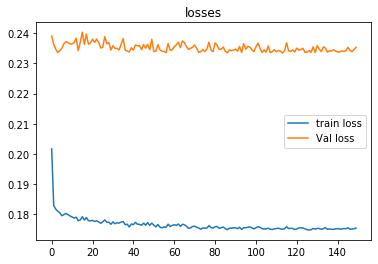

In [258]:
random.seed(0)
model = VanillaRNN(**model_params)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
opt = Optimization(model=model, loss_func=loss_func, optimizer=optimizer)
val_values_vanilla, val_preds_vanilla = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_feats=input_dims)
opt.plot_losses()

In [259]:
test_values_vanilla, test_preds_vanilla = opt.evaluate(test_loader_one, batch_size=1, n_feats=1)

In [260]:
pd.DataFrame({
    'test_val': test_values_vanilla,
    'test_pred': test_preds_vanilla
})

,test_val,test_pred
0,0.0,-0.026257
1,0.0,-0.026256
2,0.0,-0.026256
3,0.0,-0.026256
4,0.0,-0.026255
...,...,...
115,0.0,-0.026267
116,0.0,-0.026267
117,0.0,-0.026267
118,0.0,-0.026268


In [247]:
test_values_vanilla

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.23555222, 0.91500664, 0.55344057,
       0.24475195, 0.01009139, 0.        , 0.12943722, 0.22003722,
       0.00615361, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01873556, 0.35396168, 0.51604027, 0.62775582,
       0.02243194, 0.04306889, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.75532055,
       0.05138417, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.89225972, 0.41568333,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [248]:
test_preds_vanilla

array([-0.04452586, -0.04452586, -0.04452583, -0.04452586, -0.04452585,
       -0.04452583, -0.04452585, -0.04452586, -0.04452583, -0.04452586,
       -0.04452586, -0.04452586, -0.04452583, -0.0445258 , -0.04452577,
       -0.04452576, -0.04452573, -0.04452573, -0.04452573, -0.04452576,
       -0.04452577, -0.0445258 , -0.04452583, -0.04452586, -0.04452556,
       -0.04452552, -0.04452549, -0.04452547, -0.04452543, -0.04452543,
       -0.04452543, -0.04452547, -0.04452549, -0.04452552, -0.04452556,
       -0.04452556, -0.04452556, -0.04452556, -0.04452559, -0.04452553,
       -0.04452552, -0.04452553, -0.04452552, -0.04452553, -0.04452559,
       -0.04452556, -0.04452556, -0.04452556, -0.04452512, -0.0445251 ,
       -0.04452507, -0.04452506, -0.04452503, -0.04452504, -0.04452503,
       -0.04452506, -0.04452507, -0.0445251 , -0.04452512, -0.04452513,
       -0.04452518, -0.04452515, -0.04452516, -0.04452516, -0.04452513,
       -0.04452512, -0.04452513, -0.04452516, -0.04452516, -0.04

Training loss: 0.9092351496219635, val loss 0.886709064245224
Training loss: 0.821124155074358, val loss 0.796179195245107
Training loss: 0.7361190281808376, val loss 0.7059162358442942
Training loss: 0.6672765612602234, val loss 0.6156362642844518
Training loss: 0.5423183739185333, val loss 0.5230270599325498
Training loss: 0.4846752118319273, val loss 0.4282284292081992
Training loss: 0.37247797986492515, val loss 0.3789050169289112
Training loss: 0.33447419572621584, val loss 0.3552805557847023
Training loss: 0.33756530145183206, val loss 0.33672520735611516
Training loss: 0.31766029447317123, val loss 0.3456662905712922
Training loss: 0.3018483556807041, val loss 0.3585068608323733
Training loss: 0.265369423199445, val loss 0.39021044472853345


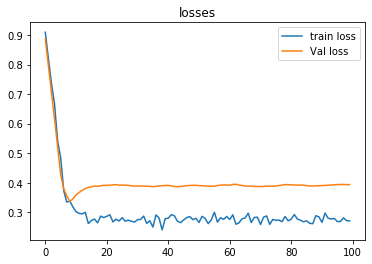

,test_val,test_pred
0,0.000000,0.213696
1,0.344352,0.208320
2,1.000000,0.209849
3,0.450793,0.210502
4,0.429142,0.213696
5,0.073159,0.208956
6,0.672383,0.209943
7,0.021944,0.209748


In [236]:
input_dims = 1
num_layers = 5
num_nodes = 5
output_dims = 1
batch_size = 7
n_epochs = 100
dropout = 0.1
lr = 1e-3
model_params = {
    'input_dims': input_dims,
    'num_nodes': num_nodes,
    'num_layers': num_layers,
    'output_dims': output_dims,
    'dropout_prob': dropout
}

model = VanillaRNN(**model_params)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
opt = Optimization(model=model, loss_func=loss_func, optimizer=optimizer)
val_values_vanilla, val_preds_vanilla = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_feats=input_dims)
opt.plot_losses()

test_values_vanilla, test_preds_vanilla = opt.evaluate(test_loader_one, batch_size=1, n_feats=1)
pd.DataFrame({
    'test_val': test_values_vanilla,
    'test_pred': test_preds_vanilla
})

Training loss: 0.7030996270477772, val loss 0.44581085443496704
Training loss: 0.3496847948990762, val loss 0.41875553131103516
Training loss: 0.2760223033837974, val loss 0.41427097221215564
Training loss: 0.2761869439855218, val loss 0.38947371145089466
Training loss: 0.2737089074216783, val loss 0.395487442612648
Training loss: 0.2661827113479376, val loss 0.40392862260341644
Training loss: 0.27259583678096533, val loss 0.41216925779978436
Training loss: 0.281256259419024, val loss 0.4027594675620397
Training loss: 0.27271267026662827, val loss 0.39524436990420025
Training loss: 0.27784634521231055, val loss 0.39929382006327313
Training loss: 0.275095735443756, val loss 0.41235530376434326
Training loss: 0.27184180403128266, val loss 0.4071376274029414


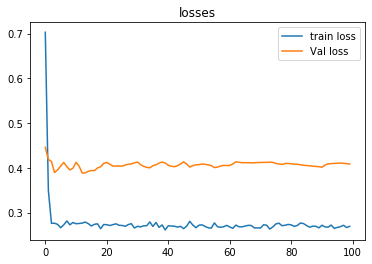

,test_val,test_pred
0,0.000000,0.366450
1,0.344352,0.344456
2,1.000000,0.357834
3,0.450793,0.362495
4,0.429142,0.366450
5,0.073159,0.362662
6,0.672383,0.355648
7,0.021944,0.356238


In [237]:
input_dims = 1
num_layers = 5
num_nodes = 5
output_dims = 1
batch_size = 7
n_epochs = 100
dropout = 0.1
lr = 1e-2
model_params = {
    'input_dims': input_dims,
    'num_nodes': num_nodes,
    'num_layers': num_layers,
    'output_dims': output_dims,
    'dropout_prob': dropout
}

model = VanillaRNN(**model_params)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
opt = Optimization(model=model, loss_func=loss_func, optimizer=optimizer)
val_values_vanilla, val_preds_vanilla = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_feats=input_dims)
opt.plot_losses()

test_values_vanilla, test_preds_vanilla = opt.evaluate(test_loader_one, batch_size=1, n_feats=1)
pd.DataFrame({
    'test_val': test_values_vanilla,
    'test_pred': test_preds_vanilla
})

Training loss: 0.6797800026834011, val loss 0.6550608476003011
Training loss: 0.5975815150886774, val loss 0.5791040460268656
Training loss: 0.5246149096637964, val loss 0.5013733382026354
Training loss: 0.4377044173888862, val loss 0.4209878562639157
Training loss: 0.3800403904169798, val loss 0.38074153785904247
Training loss: 0.3456202964298427, val loss 0.3624045054117839
Training loss: 0.3295946307480335, val loss 0.3494826406240463
Training loss: 0.3203800767660141, val loss 0.33908170523742837
Training loss: 0.3026627777144313, val loss 0.33642566204071045
Training loss: 0.3042322602123022, val loss 0.34463318934043247
Training loss: 0.28927506506443024, val loss 0.35227062925696373
Training loss: 0.2633118978701532, val loss 0.39841651419798535
Training loss: 0.27171509014442563, val loss 0.40261660516262054


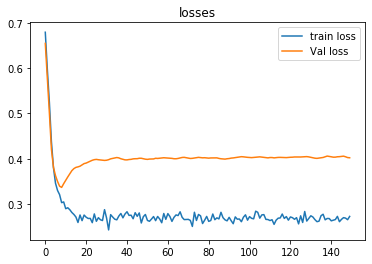

,test_val,test_pred
0,0.000000,0.295590
1,0.344352,0.295476
2,1.000000,0.295954
3,0.450793,0.296023
4,0.429142,0.295590
5,0.073159,0.295514
6,0.672383,0.295202
7,0.021944,0.296053


In [242]:
input_dims = 1
num_layers = 6
num_nodes = 5
output_dims = 1
batch_size = 7
n_epochs = 150
dropout = 0.1
lr = 1e-3
model_params = {
    'input_dims': input_dims,
    'num_nodes': num_nodes,
    'num_layers': num_layers,
    'output_dims': output_dims,
    'dropout_prob': dropout
}

model = VanillaRNN(**model_params)
loss_func = nn.L1Loss()
optimizer = optim.Adam(model.parameters(), lr=lr)
opt = Optimization(model=model, loss_func=loss_func, optimizer=optimizer)
val_values_vanilla, val_preds_vanilla = opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_feats=input_dims)
opt.plot_losses()

test_values_vanilla, test_preds_vanilla = opt.evaluate(test_loader_one, batch_size=1, n_feats=1)
pd.DataFrame({
    'test_val': test_values_vanilla,
    'test_pred': test_preds_vanilla
})